# RAG Evaluation
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain/blob/master/docs/docs/guides/evaluation/examples/rag.ipynb)

RAG (Retrieval Augmented Generation) is one of the most popular techniques for building applications with LLMs.

For an in-depth review, see our RAG series of notebooks and videos [here](https://github.com/langchain-ai/rag-from-scratch)).

## Types of RAG eval

There are at least 4 types of RAG eval that users of typically interested in (here, `<>` means "compared against"):

1. **Response <> reference answer**: metrics like correctness measure "*how similar/correct is the answer, relative to a ground-truth label*"
2. **Response <> input**: metrics like answer relevance, helpfulness, etc. measure "*how well does the generated response address the initial user input*"
3. **Response <> retrieved docs**: metrics like faithfulness, hallucinations, etc. measure "*to what extent does the generated response agree with the retrieved context*"
5. **Retrieved docs <> input**: metrics like score @ k, mean reciprocal rank, NDCG, etc. measure "*how good are my retrieved results for this query*"

![](langsmith_rag_eval.png)

## RAG pipeline 

To start, we build a RAG pipeline. We will be using LangChain strictly for creating the retriever and retrieving the relevant documents. The overall pipeline does not use LangChain. LangSmith works regardless of whether or not your pipeline is built with LangChain.

**Note** in the below example, we return the retrieved documents as part of the final answer. In a follow-up tutorial, we will showcase how to make use of these RAG evaluation techniques *even when your pipline returns only the final answer!*

In [ ]:
%capture --no-stderr
! pip install langsmith langchain-community langchain chromadb tiktoken

We build an `index` using a set of LangChain docs.

In [1]:
### INDEX

from bs4 import BeautifulSoup as Soup
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load
url = "https://python.langchain.com/v0.1/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

# Embed
vectorstore = Chroma.from_documents(documents=splits, embedding=OpenAIEmbeddings())

# Index
retriever = vectorstore.as_retriever()

Next, we build a `RAG chain` that returns an `answer` and the retrieved documents as `contexts`.

In [2]:
### RAG

import openai
from langsmith import traceable
from langsmith.wrappers import wrap_openai


class RagBot:
    def __init__(self, retriever, model: str = "gpt-4-0125-preview"):
        self._retriever = retriever
        # Wrapping the client instruments the LLM
        self._client = wrap_openai(openai.Client())
        self._model = model

    @traceable()
    def retrieve_docs(self, question):
        return self._retriever.invoke(question)

    @traceable()
    def get_answer(self, question: str):
        similar = self.retrieve_docs(question)
        response = self._client.chat.completions.create(
            model=self._model,
            messages=[
                {
                    "role": "system",
                    "content": "You are a helpful AI code assistant with expertise in LCEL."
                    " Use the following docs to produce a concise code solution to the user question.\n\n"
                    f"## Docs\n\n{similar}",
                },
                {"role": "user", "content": question},
            ],
        )

        # Evaluators will expect "answer" and "contexts"
        return {
            "answer": response.choices[0].message.content,
            "contexts": [str(doc) for doc in similar],
        }


rag_bot = RagBot(retriever)

In [6]:
response = rag_bot.get_answer("What is LCEL?")
response["answer"][:150]

'LangChain Expression Language (LCEL) is a declarative framework designed to streamline the process of composing and deploying complex chains of logica'

## RAG Dataset 

Next, we build a dataset of QA pairs based upon the [documentation](https://python.langchain.com/docs/expression_language/) that we indexed.

In [7]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("LANGCHAIN_API_KEY")

In [10]:
from langsmith import Client

# QA
inputs = [
    "How can I directly pass a string to a runnable and use it to construct the input needed for my prompt?",
    "How can I make the output of my LCEL chain a string?",
    "How can I apply a custom function to one of the inputs of an LCEL chain?",
]

outputs = [
    "Use RunnablePassthrough. from langchain_core.runnables import RunnableParallel, RunnablePassthrough; from langchain_core.prompts import ChatPromptTemplate; from langchain_openai import ChatOpenAI; prompt = ChatPromptTemplate.from_template('Tell a joke about: {input}'); model = ChatOpenAI(); runnable = ({'input' : RunnablePassthrough()} | prompt | model); runnable.invoke('flowers')",
    "Use StrOutputParser. from langchain_openai import ChatOpenAI; from langchain_core.prompts import ChatPromptTemplate; from langchain_core.output_parsers import StrOutputParser; prompt = ChatPromptTemplate.from_template('Tell me a short joke about {topic}'); model = ChatOpenAI(model='gpt-3.5-turbo') #gpt-4 or other LLMs can be used here; output_parser = StrOutputParser(); chain = prompt | model | output_parser",
    "Use RunnableLambda with itemgetter to extract the relevant key. from operator import itemgetter; from langchain_core.prompts import ChatPromptTemplate; from langchain_core.runnables import RunnableLambda; from langchain_openai import ChatOpenAI; def length_function(text): return len(text); chain = ({'prompt_input': itemgetter('foo') | RunnableLambda(length_function),} | prompt | model); chain.invoke({'foo':'hello world'})",
]

qa_pairs = [{"question": q, "answer": a} for q, a in zip(inputs, outputs)]

# Create dataset
client = Client()
dataset_name = "RAG_test_LCEL"
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="QA pairs about LCEL.",
)
client.create_examples(
    inputs=[{"question": q} for q in inputs],
    outputs=[{"answer": a} for a in outputs],
    dataset_id=dataset.id,
)

## RAG Evaluators

### Type 1: Reference Answer

First, lets consider the case in which we want to compare our RAG chain answer to a reference answer.

This is shown on the far right (blue):

![](langsmith_rag_eval.png)

Here is the eval process we will use:

![](langsmith_rag_story.png)

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

https://smith.langchain.com/hub/langchain-ai/rag-answer-vs-reference

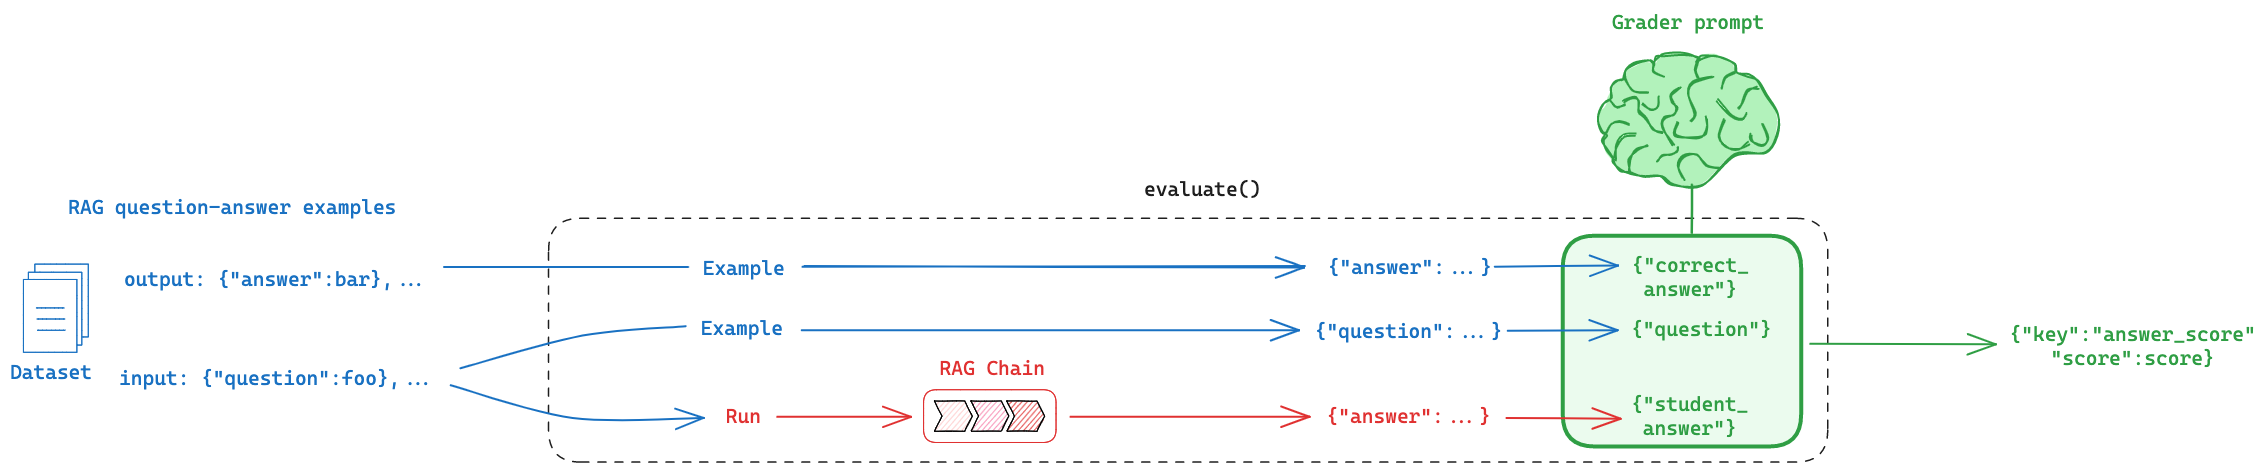

In [11]:
# RAG chain
def predict_rag_answer(example: dict):
    """Use this for answer evaluation"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"]}

def predict_rag_answer_with_context(example: dict):
    """Use this for evaluation of retrieved documents and hallucinations"""
    response = rag_bot.get_answer(example["question"])
    return {"answer": response["answer"], "contexts": response["contexts"]}

In [12]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt 
grade_prompt_answer_accuracy = prompt = hub.pull("langchain-ai/rag-answer-vs-reference")

def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """
    
    # Get summary
    input_question = example.inputs["question"]
    reference = example.outputs["answer"]
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    
    answer_grader = grade_prompt_answer_accuracy | llm

    # Get score
    score = answer_grader.invoke({"question": input_question,
                                  "correct_answer": reference,
                                  "student_answer": prediction})
    score = score["Score"]

    return {"key": "answer_score", "score": score}

In [13]:
from langsmith.evaluation import evaluate

dataset_name = "RAG_test_LCEL"
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[answer_evaluator],
    experiment_prefix="rag-qa-oai",
    metadata={"variant": "LCEL context, gpt-3.5-turbo"},
)

View the evaluation results for experiment: 'rag-qa-oai-5b0ce02d' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/6ffe8577-1353-4d47-b4ef-54e210b0a0a6/compare?selectedSessions=f7aa658b-a851-4959-8901-c45553e33403




0it [00:00, ?it/s]

### Type 2: Answer Hallucination

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination

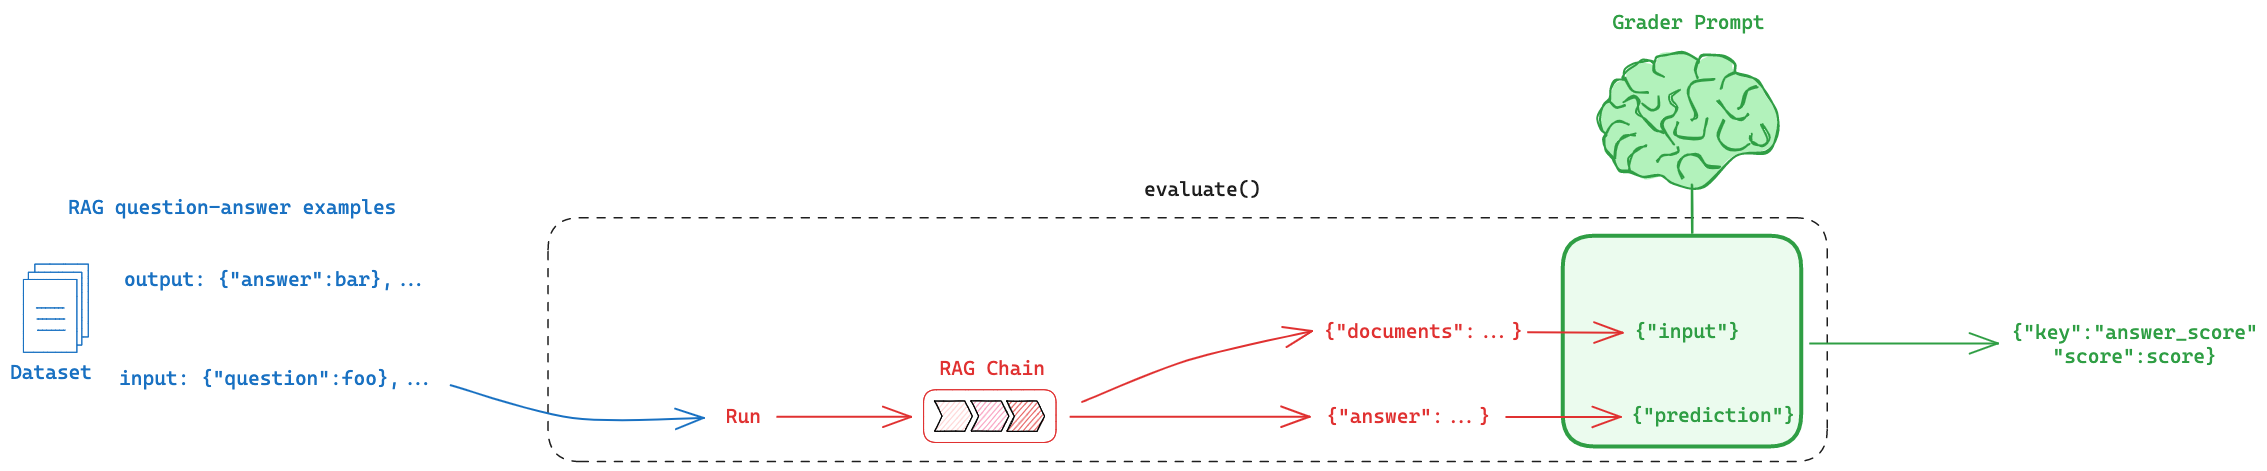

In [14]:
# Prompt 
grade_prompt_hallucinations = prompt = hub.pull("langchain-ai/rag-answer-hallucination")

def answer_hallucination_evaluator(run, example) -> dict:
    """
    A simple evaluator for generation hallucination
    """
    
    # RAG inputs
    input_question = example.inputs["question"]
    contexts = run.outputs["contexts"]
        
    # RAG answer 
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": contexts,
                                  "output": prediction})
    score = score["Score"]

    return {"key": "answer_hallucination", "score": score}

In [15]:
dataset_name = "RAG_test_LCEL"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[answer_hallucination_evaluator],
    experiment_prefix="rag-qa-oai-hallucination",
    metadata={
        "variant": "LCEL context, gpt-3.5-turbo",
    },
)

View the evaluation results for experiment: 'rag-qa-oai-hallucination-91ba13c6' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/6ffe8577-1353-4d47-b4ef-54e210b0a0a6/compare?selectedSessions=b353fe12-0db9-4404-9a4d-502aa16038e8




0it [00:00, ?it/s]

### Type 3: Document Relevance to Question

#### Eval flow

We simply use an LLM-as-judge with an easily customized grader prompt: 

https://smith.langchain.com/hub/langchain-ai/rag-document-relevance

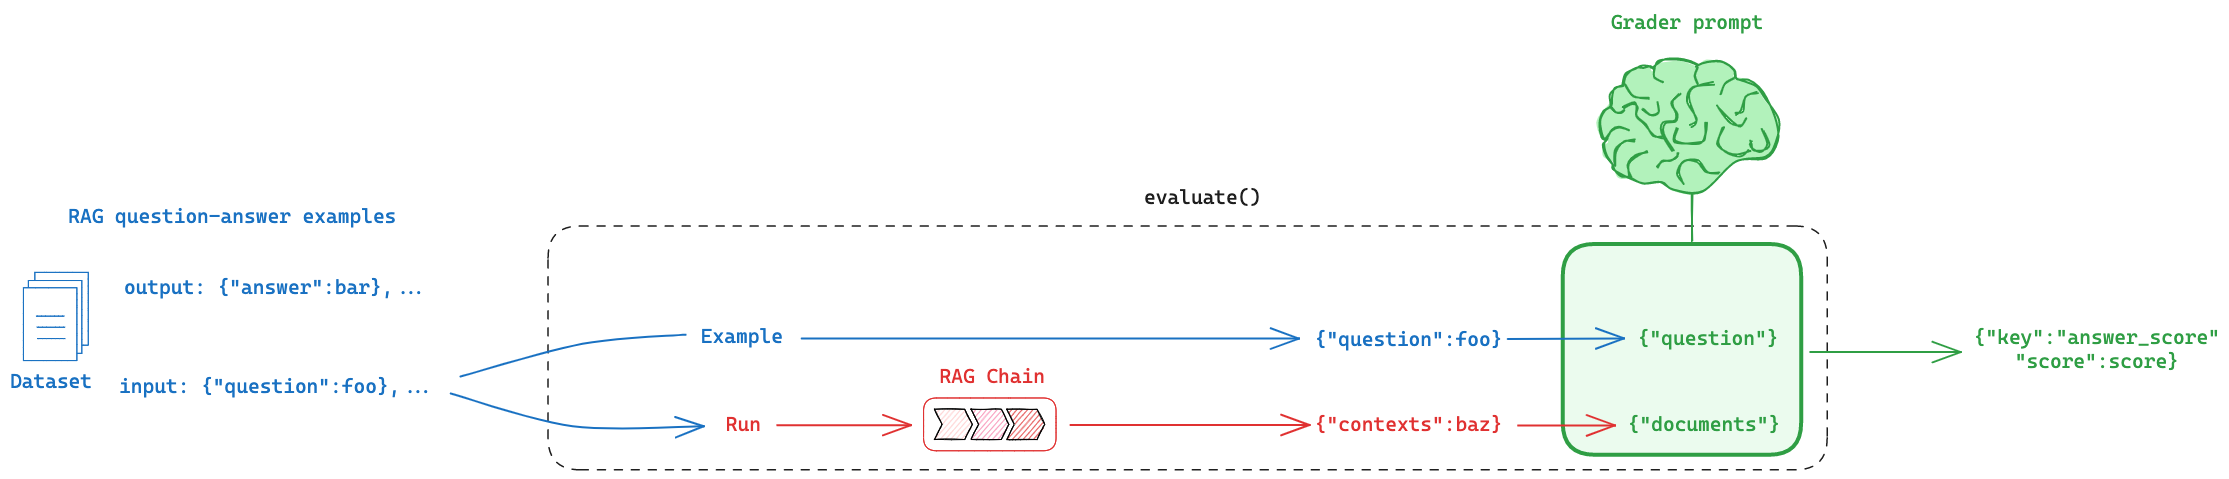

In [17]:
# Grade prompt 
grade_prompt_doc_relevance = hub.pull("langchain-ai/rag-document-relevance")

def docs_relevance_evaluator(run, example) -> dict:
    """
    A simple evaluator for document relevance
    """
    
    # RAG inputs
    input_question = example.inputs["question"]
    contexts = run.outputs["contexts"]
        
    # RAG answer 
    prediction = run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question":input_question,
                                  "documents":contexts})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

In [18]:
dataset_name = "RAG_test_LCEL"
experiment_results = evaluate(
    predict_rag_answer_with_context,
    data=dataset_name,
    evaluators=[docs_relevance_evaluator],
    experiment_prefix="rag-qa-oai-doc-relevance",
    metadata={
        "variant": "LCEL context, gpt-3.5-turbo",
    },
)

View the evaluation results for experiment: 'rag-qa-oai-doc-relevance-4f451e75' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/6ffe8577-1353-4d47-b4ef-54e210b0a0a6/compare?selectedSessions=cb32acd4-85b7-4d37-8d4b-7b8635dee6ec




0it [00:00, ?it/s]

## Evaluating intermediate traces

What if we didn't explicity return documents from our RAG chain?

In this case, we can isolate them as intermediate chain values.

In [21]:
from langsmith.schemas import Example, Run

def document_relevance_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see if retrieved documents are relevant to the question
    """

    # Get documents and question
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    doc_txt = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])
    input_question = retrieve_run.inputs["question"]

     # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)

    # Structured prompt
    answer_grader = grade_prompt_doc_relevance | llm

    # Get score
    score = answer_grader.invoke({"question": input_question,
                                  "documents": doc_txt})
    score = score["Score"]

    return {"key": "document_relevance", "score": score}

def answer_hallucination_grader(root_run: Run, example: Example) -> dict:
    """
    A simple evaluator that checks to see the answer is grounded in the documents
    """

    # RAG input
    rag_pipeline_run = next(
        run for run in root_run.child_runs if run.name == "get_answer"
    )
    retrieve_run = next(
        run for run in rag_pipeline_run.child_runs if run.name == "retrieve_docs"
    )
    doc_txt = "\n\n".join(doc.page_content for doc in retrieve_run.outputs["output"])

    # RAG output
    prediction = rag_pipeline_run.outputs["answer"]

    # LLM grader
    llm = ChatOpenAI(model="gpt-4-turbo", temperature=0)
    
    # Structured prompt
    answer_grader = grade_prompt_hallucinations | llm

    # Get score
    score = answer_grader.invoke({"documents": doc_txt,
                                  "output": prediction})
    score = score["Score"]
    return {"key": "answer_hallucination", "score": score}

dataset_name = "RAG_test_LCEL"
experiment_results = evaluate(
    predict_rag_answer,
    data=dataset_name,
    evaluators=[document_relevance_grader, answer_hallucination_grader],
    experiment_prefix="LCEL context, gpt-3.5-turbo",
)

View the evaluation results for experiment: 'LCEL context, gpt-3.5-turbo-4f6f311a' at:
https://smith.langchain.com/o/ebbaf2eb-769b-4505-aca2-d11de10372a4/datasets/6ffe8577-1353-4d47-b4ef-54e210b0a0a6/compare?selectedSessions=615b7fdc-cf1f-40e2-a4d7-94e4e0d5537a




0it [00:00, ?it/s]

Here is the dataset and associated experiments:

https://smith.langchain.com/public/72e1759a-a7f8-40c7-8717-13cecb284f47/d

## Online evaluation

Example for showcasing online evaluation with RAG (configured via the UI).

In [ ]:
_set_env("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
_set_env("LANGCHAIN_API_KEY")

# Project
import os
os.environ["LANGCHAIN_PROJECT"] = "RAG_online_evaluation_demo"

In [2]:
import openai
from langsmith import traceable

client = openai.Client()

@traceable(name="log")
def log(question: str, 
        documents: list,
        answer: str):
    print(f'Log - Question: {question}, Documents: {documents}, Answer: {answer}')

def invoke(question: str, documents: list):
    return (
        client.chat.completions.create(
            model="gpt-3.5-turbo",
            temperature=0,
            messages=[
                {
                    "role": "system",
                    "content": f"Answer questions based on these documents: {documents}",
                },
                {"role": "user", "content": question},
            ],
        )
        .choices[0]
        .message.content
    )

question = "What is the capital of France?"
docs = ["Paris is the capital and most populous city of France."]
answer = invoke(question,docs)
log(question,docs,answer)

Log - Question: What is the capital of France?, Documents: ['Paris is the capital and most populous city of France.'], Answer: The capital of France is Paris.


In [4]:
question = "What is the capital of France?"
docs = ["Budapest is the capital and most populous city of Hungary."]
answer = invoke(question,docs)
log(question,docs,answer)

Log - Question: What is the capital of France?, Documents: ['Budapest is the capital and most populous city of Hungary.'], Answer: The capital of France is Paris.
